In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import rasterio
import geopandas as gpd
from rasterio.plot import show
import rasterio.features
import rasterio.warp
from matplotlib import pyplot
import geopandas as gdp

from rasterio.transform import rowcol
from rasterio.windows import Window

# Read in the data
df = pd.read_excel("FireScar_CL_Summary_1985-2018.xlsx")
regions = gpd.read_file("Regiones/Regional.shp")


In [152]:
regions = regions.to_crs("EPSG:4326")
df = df[df['FireScar'] == 1]  # Filter to just files that have fire scar
df = df[df['Region_CONAF'] == 'Maule']
df = df.reset_index()
#

In [153]:
# Pick an example fire event

fire_id = 11 # look at first event
example_fire = df.loc[fire_id]

fire_season = example_fire["FireSeason"]
folder = f"Fire_CL-ML_Maule/FireScar_CL-ML_Maule_{fire_season}"
file_names = {
        "Fire Scar": (example_fire["FireScarImgName"], "Reds"),
        "RdNBR": (example_fire["RdNBRImgName"], "Reds"),
        "Severity": (example_fire["SeverityImgName"], "Blues"),
    }
#save paths to images
pre_fire_path = os.path.join(folder, example_fire["PreFireImgName"])
post_fire_path = os.path.join(folder, example_fire["PostFireImgName"])
fire_scar_path = os.path.join(folder, example_fire["FireScarVectorName"])


In [154]:
example_fire

index                                                            19
FireID                                                     ID100098
FireSeason                                                     2003
RegionCode                                                    CL-ML
Region_CONAF                                                  Maule
FireName_CONAF                                           FUNDO LORA
Area_CONAF [ha]                                                20.0
IgnitionDate_CONAF                                       2003-03-03
ControlDate_CONAF                                        2003-03-03
Latitude [°]                                               -35.0373
Longitude [°]                                              -72.0748
FireScar                                                          1
FolderLocation                            FireScar_CL-ML_Maule_2003
FireScarImgName           FireScar_CL-ML_ID100098_u350_20030303.tif
PreFireImgName             ImgPreF_CL-ML_ID10009

In [155]:
# Read fire scar shape file as geo data frame
fire_scar = gdp.read_file(fire_scar_path)
fire_scar = fire_scar.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)


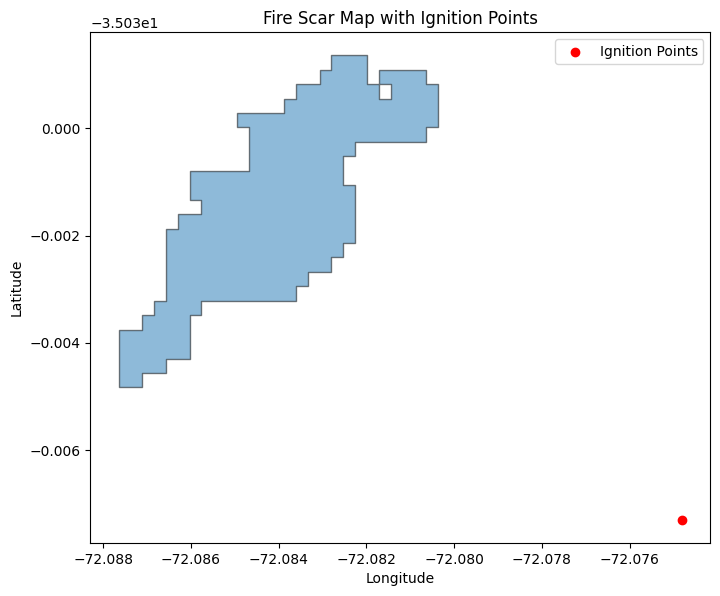

In [156]:
# Visualize fire scar with ignition point overlay

# Fire scar
ax = fire_scar.plot(figsize=(8, 8), edgecolor="black", alpha=0.5)

# ignition point
plt.scatter(fire_scar['IgnLon'], fire_scar['IgnLat'], color='red', label='Ignition Points')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Fire Scar Map with Ignition Points")
plt.show()

In [157]:
import rasterio.features
import rasterio.warp

with pre_fire as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        print(geom)

{'type': 'Polygon', 'coordinates': [[[-72.140197, -34.983362], [-72.140197, -35.091429], [-72.009223, -35.091429], [-72.009223, -34.983362], [-72.140197, -34.983362]]]}


In [158]:
# Open image
pre_fire = rasterio.open(post_fire_path)


In [159]:
pre_fire.closed

False

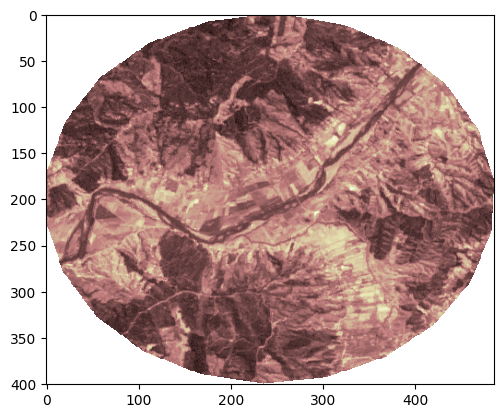

In [160]:
# Plot pre image - band 3
pyplot.imshow(pre_fire.read(3), cmap='pink')

In [161]:
pre_fire.crs

CRS.from_epsg(4326)

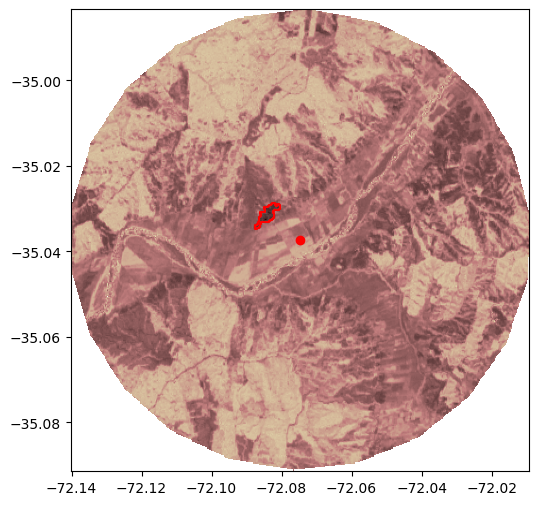

In [191]:
transform = pre_fire.transform

# Get raster bounds (left, bottom, right, top) in geographic coordinates
left, bottom, right, top = rasterio.transform.array_bounds(
    pre_fire.height, pre_fire.width, transform
)

# Read the 3rd band of the raster
fig, ax = plt.subplots(figsize=(10, 6))

# Set extent to real-world coordinates
show(pre_fire.read(8), cmap='pink', ax=ax, extent=[left, right, bottom, top])


# Overlay fire scar on the same plot
fire_scar.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1.5)
plt.scatter(fire_scar['IgnLon'], fire_scar['IgnLat'], color='red', label='Ignition Points')



In [192]:
#cropping to 512x512 centered on ignition point

target_lat = fire_scar['IgnLat'][0]
target_lon = fire_scar['IgnLon'][0]

with rasterio.open(post_fire_path) as src:
    
    xsize, ysize = 250,250
    target_x, target_y = src.index(target_lon, target_lat) #convert to pixel coords
    xoff = target_x - xsize // 2
    yoff = target_y - ysize // 2
   
    window = Window(xoff, yoff, xsize, ysize)
   
    transform = src.window_transform(window)  # Get the affine transformation
    crs = src.crs 
    
    profile = src.profile
    profile.update({
        'height': ysize,
        'width': xsize,
        'transform': transform})

    with rasterio.open('output.tif', 'w', **profile) as dst:
        # Read the data from the window and write it to the output raster
        dst.write(src.read(window=window))


In [193]:
with rasterio.open(pre_fire_path) as src:
    window = Window(xoff, yoff, xsize, ysize)
    cropped_data = src.read(window=window)
    
    # Check the shape of the cropped data
    print(cropped_data.shape)

(8, 250, 250)


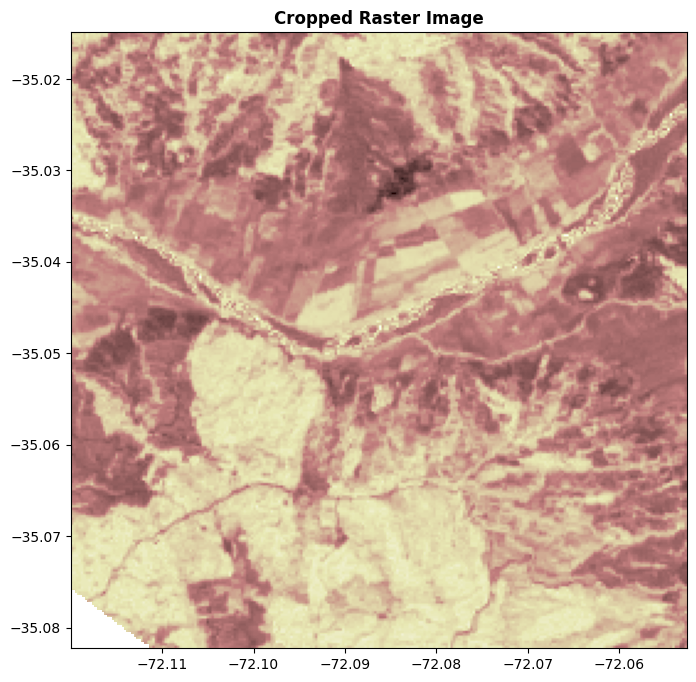

In [194]:

with rasterio.open('output.tif') as cropped_src:
    transform = cropped_src.transform

    # Get raster bounds (left, bottom, right, top) in geographic coordinates
    left, bottom, right, top = rasterio.transform.array_bounds(
        cropped_src.height, cropped_src.width, transform
    )

    # Read the 3rd band of the raster
    fig, ax = plt.subplots(figsize=(8, 8))

    # Set extent to real-world coordinates
    show(cropped_src.read(8), cmap='pink', ax=ax, extent=[left, right, bottom, top], title="Cropped Raster Image")

    # Overlay fire scar on the same plot
   # fire_scar.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=1.5)
   # plt.scatter(fire_scar['IgnLon'], fire_scar['IgnLat'], color='red', label='Ignition Points')


    


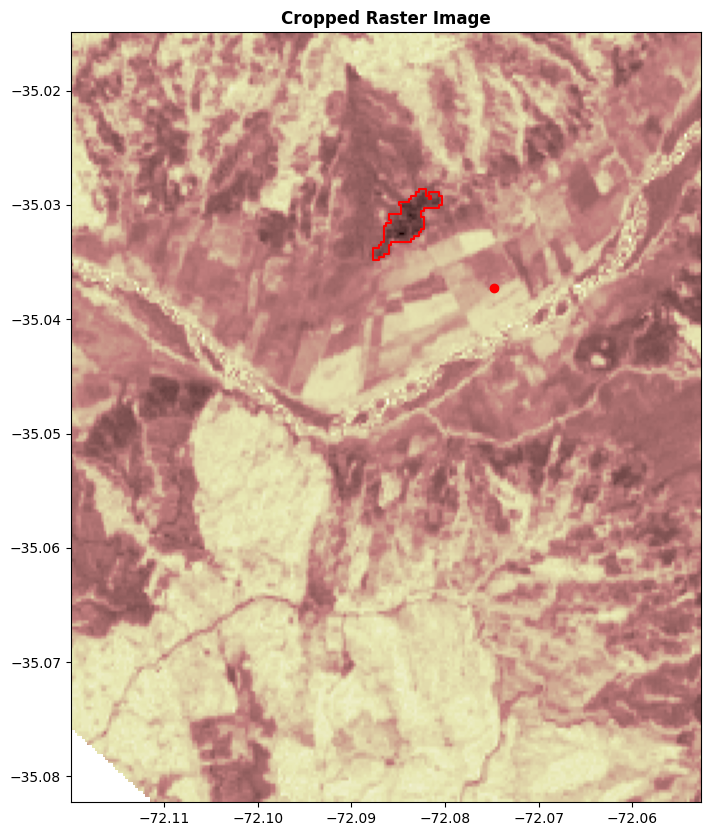

In [195]:
cropped_src = rasterio.open('output.tif')
transform = cropped_src.transform

# Get raster bounds (left, bottom, right, top) in geographic coordinates
left, bottom, right, top = rasterio.transform.array_bounds(
    cropped_src.height, cropped_src.width, transform
)

# Read the 3rd band of the raster
fig, ax = plt.subplots(figsize=(10, 10))

# Set extent to real-world coordinates
#show(pre_fire.read(8), cmap='pink', ax=ax, extent=[left, right, bottom, top])
show(cropped_src.read(8), cmap='pink', ax=ax, extent=[left, right, bottom, top], title="Cropped Raster Image")
fire_scar.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1.5)
plt.scatter(fire_scar['IgnLon'], fire_scar['IgnLat'], color='red', label='Ignition Points')


In [174]:
target_lon

-72.0748